# Dataset Analysis

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn as nil
from tqdm import tqdm
import matplotlib.pyplot as plt
from porespy.metrics import regionprops_3D
from nilearn.plotting import plot_glass_brain
from skimage.measure import regionprops, label

## Dataset - UCSF_BrainMetastases

### Description 

- 560 brain MRIs from 412 patients with expert annotations of 5136 brain metastases

- Abreviations
  - T1. T1-weighted spoiled gradient-echo
  - FLAIR. Fluid-Attenuated Inversion Recovery
  
- Data consists of registered and skull stripped:
  - T1 post-contrast
  - T1 pre-contrast
  - 2D-post contrast T2 FLAIR
  - Subtraction (T1 pre-contrast - T1 post-contrast) 
  - voxelwise segmentations of enhancing brain metastases in NifTI format

- The dataset also includes patient demographics, surgical status and primary cancer types.
  - mean age, 61 ± [SD] 12 years
  - 238 female, 174 male
  - January 1st 2017 - February 29th, 2020

- Scanners
  - 373 (66%) - 1.5 Tesla GE SignaHDxt 
  - 149 (27%) - 1.5 Tesla Philips Achieva
  - 38  (7%)  - 3.0 Tesla GE Discovery MR750

- Measurement Parameters - T1 (pre/post)
  - Repetition time 8.8msec
  - Echo time 3.3 msec
  - Inversion time 450 msec
  - Flip angle 11°
  - Matrix size 256 x 256 x 106
  - Voxel size 0.71 x 0.71 x 1.5 mm

- Measurement Parameters - 2D T2 FLAIR
  - Repetition time 9175 msec
  - Echo time 109 msec
  - Inversion time 2600 msec
  - Matrix size 256 x 256 x 38
  - Voxel size 0.98 x 0.98 x 5 mm

- Segmentation/Annotation created using [ITKSNAP](http://www.itksnap.org/)

- Preprocessing
  - From DCOM to NifTI using `dcm2niix`
  - T1 and FLAIR registration to T1-post space using `FLIRT` (FMRIB Software Library) through rigid registration (6 degrees of freedom)
  - Subtraction image created using `fslmaths` (FMRIB Software Library)
  - skull stripping network using in-house `nnU-Net` https://github.com/rachitsaluja/UCSF-BMSR-benchmarks

- nnU-Net
  - a 3D fully-convolutional network (3D Res-U-Net)
  - Performs: z-score normalization, resampling, augmentation
  - Batch size of 6
  - Train Set - BraTS 2021 dataset
  - 3D patch size was auto selected to be 64 x 192 x 160
  - RTX 3090 GPU (CUDA version 11.2; NVIDIA corporation, Santa Clara, CA; 24 GB memory) 
  - 1000 epochs 
  - Cost Function. Combination of crossventropy and Dice loss function
  - Result. Median Dice of 0.89
  
"No other image normalization, scaling/resizing or atlas registration was performed prior to input into the neural network."

### Folder Structure

```
- data
|--- UCSF_BrainMetastases_TRAIN
|    |--- patient_ID
|         |--- patient_BraTS-seg.nii.gz
|         |--- patient_FLAIR.nii.gz
|         |--- patient_seg.nii.gz
|         |--- patient_subtraction.nii.gz
|         |--- patient_T1post.nii.gz
|         |--- patient_T1pre.nii.gz
|         |--- patient_T2Synth.nii.gz
|--- TableS1_UCSF_BrainMetastases_SubjectInfo.xlsx
```

Where:
- patient_ID - unique identifier for each patient
- BraTS-seg - ground truth segmentation with ET, WT, and TC labels
- FLAIR - 2D T2 FLAIR
- seg - ground truth segmentation not in BraTS format
- subtraction - T1 pre-contrast - T1 post-contrast
- T1post - T1 post-contrast
- T1pre - T1 pre-contrast
- T2Synth - 2D T2 FLAIR registered to T1 post-contrast space
- Table - patient demographics, surgical status and primary cancer types

In [2]:
# Paths
root_dir = './data/'
images_dir = root_dir + 'UCSF_BrainMetastases_TRAIN/'

# Load Subjects Information
df = pd.read_excel(root_dir + 'TableS1_UCSF_BrainMetastases_SubjectInfo.xlsx')
df.drop(columns=['Unnamed: 13', 'BraTS_ID', 'TRAIN or TEST', 'Prior Craniotomy/Biopsy/Resection'], inplace=True)

# Split Train/Val/Test - 70%/10%/20%
df['split'] = np.random.choice(['train', 'test', 'val'], p=[.7, .2, .1], size=(len(df),))

# Shuffle data
df = df.sample(frac=1, random_state=33).reset_index(drop=True)

# Load Images/Segmentations Paths
df['T1pre'] = [images_dir + id + '/' + id + '_T1pre.nii.gz' for id in df['SubjectID']]
df['FLAIR'] = [images_dir + id + '/' + id + '_FLAIR.nii.gz' for id in df['SubjectID']]
df['T1post'] = [images_dir + id + '/' + id + '_T1post.nii.gz' for id in df['SubjectID']]
df['T2Synth'] = [images_dir + id + '/' + id + '_T2Synth.nii.gz' for id in df['SubjectID']]
df['Seg'] = [images_dir + id + '/' + id + '_seg.nii.gz' for id in df['SubjectID']]
df['BraTS-seg'] = [images_dir + id + '/' + id + '_BraTS-seg.nii.gz' for id in df['SubjectID']]

df

,SubjectID,Sex,Age,CancerType,ScannerType,Scanner Strength (Tesla),In-plane voxel size (mm),Slice Thickness (mm),Matrix size,NumberMetastases,VolumeMetastases_mm3,split,T1pre,FLAIR,T1post,T2Synth,Seg,BraTS-seg
0,100324A,Female,68,Lung,GE 1.5 T Signa HDxt,1.5,1.17x1.17,1.5,256x256x98,34,11080.871970,train,./data/UCSF_BrainMetastases_TRAIN/100324A/1003...,./data/UCSF_BrainMetastases_TRAIN/100324A/1003...,./data/UCSF_BrainMetastases_TRAIN/100324A/1003...,./data/UCSF_BrainMetastases_TRAIN/100324A/1003...,./data/UCSF_BrainMetastases_TRAIN/100324A/1003...,./data/UCSF_BrainMetastases_TRAIN/100324A/1003...
1,100279B,Female,71,Renal,GE 1.5 T Signa HDxt,1.5,0.86x0.86,1.5,256x256x104,18,6200.650296,test,./data/UCSF_BrainMetastases_TRAIN/100279B/1002...,./data/UCSF_BrainMetastases_TRAIN/100279B/1002...,./data/UCSF_BrainMetastases_TRAIN/100279B/1002...,./data/UCSF_BrainMetastases_TRAIN/100279B/1002...,./data/UCSF_BrainMetastases_TRAIN/100279B/1002...,./data/UCSF_BrainMetastases_TRAIN/100279B/1002...
2,100222B,Female,66,GU Fallopian,GE 1.5 T Signa HDxt,1.5,0.86x0.86,1.5,256x256x100,7,787.683109,test,./data/UCSF_BrainMetastases_TRAIN/100222B/1002...,./data/UCSF_BrainMetastases_TRAIN/100222B/1002...,./data/UCSF_BrainMetastases_TRAIN/100222B/1002...,./data/UCSF_BrainMetastases_TRAIN/100222B/1002...,./data/UCSF_BrainMetastases_TRAIN/100222B/1002...,./data/UCSF_BrainMetastases_TRAIN/100222B/1002...
3,100312A,Female,77,GU Urothelial,GE 3.0 T Discovery MR750,3.0,0.53x0.53,2.0,512x136x512,1,11564.154053,test,./data/UCSF_BrainMetastases_TRAIN/100312A/1003...,./data/UCSF_BrainMetastases_TRAIN/100312A/1003...,./data/UCSF_BrainMetastases_TRAIN/100312A/1003...,./data/UCSF_BrainMetastases_TRAIN/100312A/1003...,./data/UCSF_BrainMetastases_TRAIN/100312A/1003...,./data/UCSF_BrainMetastases_TRAIN/100312A/1003...
4,100305C,Female,47,Colon,GE 3.0 T Discovery MR750,3.0,1.02x1.02,1.0,256x256x166,10,14953.864833,train,./data/UCSF_BrainMetastases_TRAIN/100305C/1003...,./data/UCSF_BrainMetastases_TRAIN/100305C/1003...,./data/UCSF_BrainMetastases_TRAIN/100305C/1003...,./data/UCSF_BrainMetastases_TRAIN/100305C/1003...,./data/UCSF_BrainMetastases_TRAIN/100305C/1003...,./data/UCSF_BrainMetastases_TRAIN/100305C/1003...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,100199A,Female,78,Lung,GE 1.5 T Signa HDxt,1.5,0.86x0.86,1.5,256x256x104,4,443.140990,train,./data/UCSF_BrainMetastases_TRAIN/100199A/1001...,./data/UCSF_BrainMetastases_TRAIN/100199A/1001...,./data/UCSF_BrainMetastases_TRAIN/100199A/1001...,./data/UCSF_BrainMetastases_TRAIN/100199A/1001...,./data/UCSF_BrainMetastases_TRAIN/100199A/1001...,./data/UCSF_BrainMetastases_TRAIN/100199A/1001...
457,100142A,Female,64,Neuroendocrine,GE 1.5 T Signa HDxt,1.5,0.86x0.86,1.5,256x256x106,2,1197.588524,val,./data/UCSF_BrainMetastases_TRAIN/100142A/1001...,./data/UCSF_BrainMetastases_TRAIN/100142A/1001...,./data/UCSF_BrainMetastases_TRAIN/100142A/1001...,./data/UCSF_BrainMetastases_TRAIN/100142A/1001...,./data/UCSF_BrainMetastases_TRAIN/100142A/1001...,./data/UCSF_BrainMetastases_TRAIN/100142A/1001...
458,100240A,Female,63,Breast,GE 1.5 T Signa HDxt,1.5,0.98x0.98,1.5,256x256x126,21,9227.507479,train,./data/UCSF_BrainMetastases_TRAIN/100240A/1002...,./data/UCSF_BrainMetastases_TRAIN/100240A/1002...,./data/UCSF_BrainMetastases_TRAIN/100240A/1002...,./data/UCSF_BrainMetastases_TRAIN/100240A/1002...,./data/UCSF_BrainMetastases_TRAIN/100240A/1002...,./data/UCSF_BrainMetastases_TRAIN/100240A/1002...
459,100361B,Female,66,Breast,GE 1.5 T Signa HDxt,1.5,0.86x0.86,1.5,256x256x100,16,4089.083481,train,./data/UCSF_BrainMetastases_TRAIN/100361B/1003...,./data/UCSF_BrainMetastases_TRAIN/100361B/1003...,./data/UCSF_BrainMetastases_TRAIN/100361B/1003...,./data/UCSF_BrainMetastases_TRAIN/100361B/1003...,./data/UCSF_BrainMetastases_TRAIN/100361B/1003...,./data/UCSF_BrainMetastases_TRAIN/100361B/1003...


## Data Exploration

1. Not all the subjects jave BraTS Segmentation annotations

In [3]:
print('Total length of the dataframe:', len(df))

# Drop Subjects with no BraTS-seg annotation
for path in df['BraTS-seg']:
  if not os.path.isfile(path):
    df = df[df['BraTS-seg'] != path]

print('Lenght after dropping subject with no BraTS Segmentation Annotation:', len(df))

Total length of the dataframe: 461
Lenght after dropping subject with no BraTS Segmentation Annotation: 324


2. Each image has a number of tumors and each tumor has a different volume

    Two libraries will be used to explore the dataset: PoresPy & SciKit-Image

    **PoresPy extracted properties - P**

        ['label', 'slice', 'mask', 'slices', 'volume', 'bbox_volume', 'border', 'dt', 'inscribed_sphere', 'sphericity', 'skeleton', 'surface_area', 'surface_mesh_vertices', 'surface_mesh_simplices', 'convex_volume', 'num_pixels', 'area', 'bbox', 'area_bbox', 'centroid', 'area_convex', 'image_convex', 'coords_scaled', 'coords', 'eccentricity', 'equivalent_diameter_area', 'euler_number', 'extent', 'feret_diameter_max', 'area_filled', 'image_filled', 'image', 'inertia_tensor', 'inertia_tensor_eigvals', 'image_intensity', 'centroid_local', 'intensity_max', 'intensity_mean', 'intensity_min', 'axis_major_length', 'axis_minor_length', 'moments', 'moments_central', 'moments_hu', 'moments_normalized', 'orientation', 'perimeter', 'perimeter_crofton', 'solidity', 'centroid_weighted', 'centroid_weighted_local', 'moments_weighted', 'moments_weighted_central', 'moments_weighted_hu', 'moments_weighted_normalized']

    **SciKit-Image extracted properties: - S**
    
        [areafloat, area_bboxfloat, area_convexfloat, area_filledfloat, axis_major_lengthfloat, axis_minor_lengthfloat, bboxtuple, centroidarray, centroid_localarray, centroid_weightedarray, centroid_weighted_localarray, coords_scaled(N, 2) ndarray, coords(N, 2) ndarray, eccentricityfloat, equivalent_diameter_areafloat, euler_numberint, extentfloat, feret_diameter_maxfloat, image(H, J) ndarray, image_convex(H, J) ndarray, image_filled(H, J) ndarray, image_intensityndarray, inertia_tensorndarray, inertia_tensor_eigvalstuple, intensity_maxfloat, intensity_meanfloat, intensity_minfloat, labelint, moments(3, 3) ndarray, moments_central(3, 3) ndarray, moments_hutuple, moments_normalized(3, 3) ndarray, moments_weighted(3, 3) ndarray, moments_weighted_central(3, 3) ndarray, moments_weighted_hutuple, moments_weighted_normalized(3, 3) ndarray, num_pixelsint, orientationfloat, perimeterfloat, perimeter_croftonfloat, slicetuple of slices, solidityfloat]

In [9]:
tumors_df = pd.DataFrame(columns=['SubjectID', 'NumberMetastases - NM', 'VolumeMetastases_mm3 - V', 
                                  'Porespy - NM', 'P - V', 'P - V Max', 'P - V Min', 'P - V Mean', 'P - V Std', 'P - V Diff'
                                  'Skimage - NM', 'S - V', 'S - V Max', 'S - V Min', 'S - V Mean', 'S - V Std', 'S - V Diff'])

for i, image in tqdm(enumerate(df['Seg'].head())):

    # Get
    nifti_img= nib.load(image)
    i_data = nifti_img.get_fdata()
    i_header = nifti_img.header
    i_label = label(i_data) 
    voxel_volume = np.prod(i_header.get_zooms())

    # Porespy
    porespy_props = regionprops_3D(i_label)
    porespy_volumes = [prop.area * voxel_volume for prop in porespy_props]

    # Skimage
    skimage_props = regionprops(i_label)
    skimage_volumes = [prop.area * voxel_volume for prop in skimage_props]

    # Store
    tumors_df.loc[len(tumors_df)] = {'SubjectID': df['SubjectID'].iloc[i],
                                     'NumberMetastases - NM': df['NumberMetastases'].iloc[i],
                                     'VolumeMetastases_mm3 - V': df['VolumeMetastases_mm3'].iloc[i],
                                     'P - NM': len(porespy_volumes),
                                     'P - V': np.sum(porespy_volumes),
                                     'P - V Max': np.max(porespy_volumes),
                                     'P - V Min': np.min(porespy_volumes),
                                     'P - V Mean': np.mean(porespy_volumes),
                                     'P - V Std': np.std(porespy_volumes),
                                     'P - V Diff': abs(np.sum(porespy_volumes) - df['VolumeMetastases_mm3'].iloc[i]),
                                     'S - NM': len(skimage_volumes),
                                     'S - V': np.sum(skimage_volumes),
                                     'S - V Max': np.max(skimage_volumes),
                                     'S - V Min': np.min(skimage_volumes),
                                     'S - V Mean': np.mean(skimage_volumes),
                                     'S - V Std': np.std(skimage_volumes),
                                     'S - V Diff': abs(np.sum(skimage_volumes) - df['VolumeMetastases_mm3'].iloc[i])}
    
# Save
#tumors_df.to_csv(root_dir + 'tumors.csv', index=False)
    
tumors_df

5it [00:02,  2.03it/s]


,SubjectID,NumberMetastases - NM,VolumeMetastases_mm3 - V,Porespy - NM,P - V,P - V Max,P - V Min,P - V Mean,P - V Std,P - V DiffSkimage - NM,S - V,S - V Max,S - V Min,S - V Mean,S - V Std,S - V Diff
0,100324A,34,11080.871970,NaN,11080.871785,8126.796652,8.240098,369.362393,1444.914572,NaN,11080.871785,8126.796652,8.240098,369.362393,1444.914572,1.854015e-04
1,100279B,18,6200.650296,NaN,6200.650213,2005.212951,4.431410,344.480567,511.602309,NaN,6200.650213,2005.212951,4.431410,344.480567,511.602309,8.342561e-05
2,100222B,7,787.683109,NaN,787.683098,377.777689,8.862820,112.526157,135.891366,NaN,787.683098,377.777689,8.862820,112.526157,135.891366,1.059775e-05
3,100312A,1,11564.154053,NaN,11564.154053,11564.154053,11564.154053,11564.154053,0.000000,NaN,11564.154053,11564.154053,11564.154053,11564.154053,0.000000,7.457857e-11
4,100174A,4,1134.440933,NaN,1134.440918,928.380361,4.431410,283.610229,379.671883,NaN,1134.440918,928.380361,4.431410,283.610229,379.671883,1.526314e-05


3. Distributions

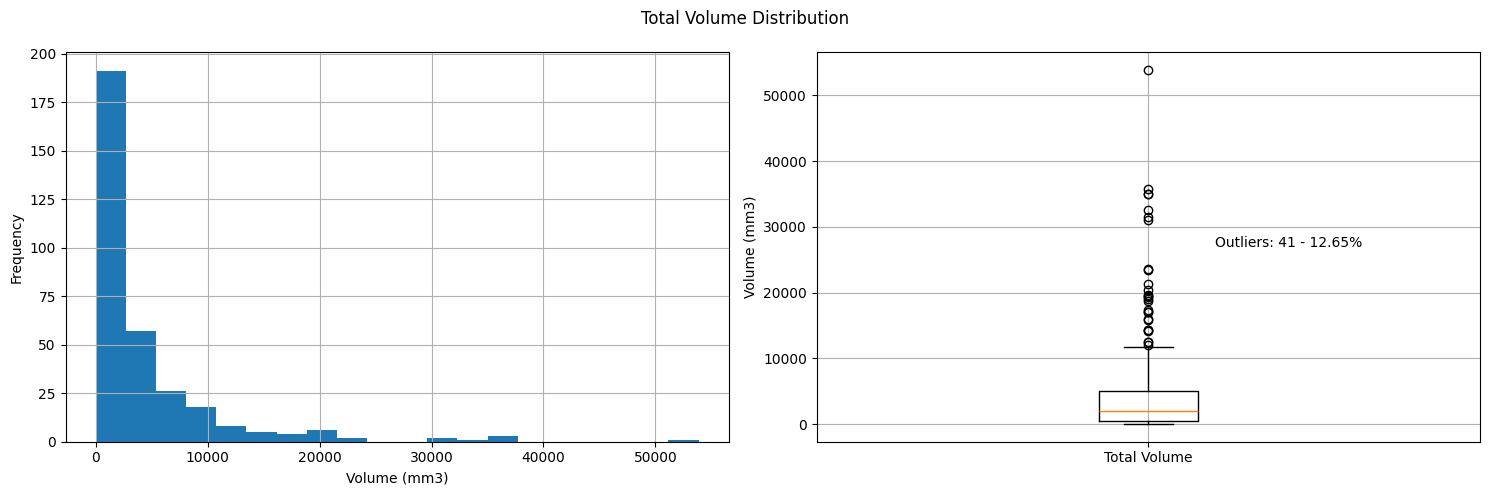

In [ ]:
# Total Volume Distribution
plt.figure(figsize=(15, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(tumors_df['VolumeMetastases_mm3 - V'], bins=20)
plt.xlabel('Volume (mm3)')
plt.ylabel('Frequency')
plt.grid()

# Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(tumors_df['VolumeMetastases_mm3 - V'])
plt.ylabel('Volume (mm3)')
plt.xticks([1], ['Total Volume'])
plt.text(1.1, 27000, 'Outliers: ' + str(len(tumors_df[tumors_df['VolumeMetastases_mm3 - V'] > 10000])) + ' - ' + str(round(len(tumors_df[tumors_df['VolumeMetastases_mm3 - V'] > 10000])/len(tumors_df)*100, 2)) + '%')
plt.grid()

plt.suptitle('Total Volume Distribution')
plt.tight_layout()
plt.show()

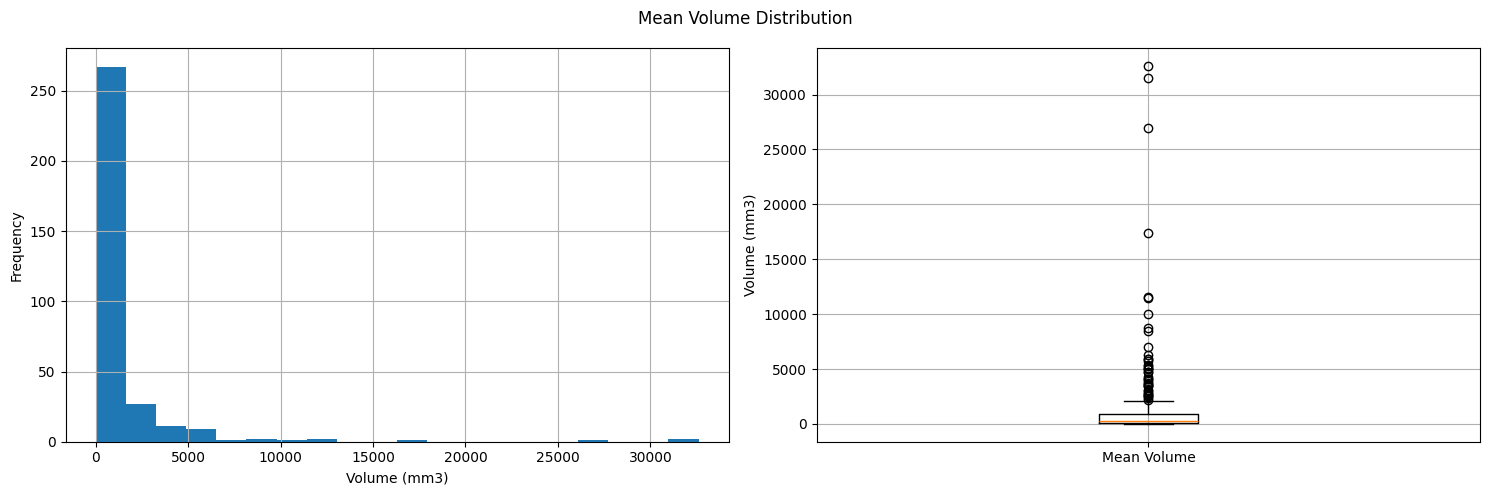

In [ ]:
# Mean Volume Distribution
plt.figure(figsize=(15, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(tumors_df['S - V Mean'], bins=20)
plt.xlabel('Volume (mm3)')
plt.ylabel('Frequency')
plt.grid()

# Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(tumors_df['S - V Mean'])
plt.ylabel('Volume (mm3)')
plt.xticks([1], ['Mean Volume'])
plt.grid()

plt.suptitle('Mean Volume Distribution')
plt.tight_layout()
plt.show()

4. Two types of segmentations

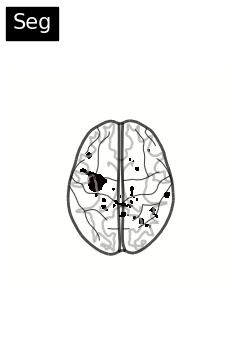

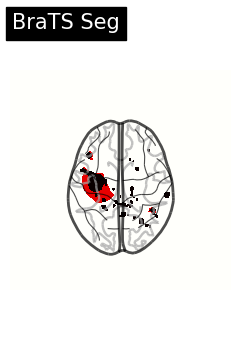

In [ ]:
# Images
seg = list(df['Seg'])[0]
seg = nib.load(seg)
b_seg = list(df['BraTS-seg'])[0]
b_seg = nib.load(b_seg)

# Plots
disp_seg = plot_glass_brain(seg, title='Seg', display_mode='z', annotate=False)
disp_b_seg = plot_glass_brain(b_seg, title='BraTS Seg', display_mode='z', annotate=False)
